<a href="https://colab.research.google.com/github/Casssiee/School-Workforce-Pressure-Funding-Allocation-Analysis/blob/main/Data_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Load data

In [ ]:
from google.colab import files

print("Please upload 'fact_performance.csv', 'fact_enrolments.csv', and 'dim_schools.csv' and 'raw_funding_requests.csv")
uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

Please upload 'fact_performance.csv', 'fact_enrolments.csv', and 'dim_schools.csv' and 'raw_funding_requests.csv


Saving dim_schools.csv to dim_schools.csv
Saving fact_enrolments.csv to fact_enrolments.csv
Saving fact_performance.csv to fact_performance.csv
Saving raw_funding_requests.csv to raw_funding_requests.csv
User uploaded file "dim_schools.csv" with length 5680 bytes
User uploaded file "fact_enrolments.csv" with length 6744 bytes
User uploaded file "fact_performance.csv" with length 7183 bytes
User uploaded file "raw_funding_requests.csv" with length 7105 bytes


In [ ]:
performance = pd.read_csv('fact_performance.csv')
enrolments = pd.read_csv('fact_enrolments.csv')
schools = pd.read_csv('dim_schools.csv')
funding = pd.read_csv('raw_funding_requests.csv')

In [ ]:
performance.head(20)

,School_ID,Year,Avg_Attendance_Pct,NAPLAN_Score_Avg
0,2000,2022,88.9,526.0
1,2000,2023,90.3,528.0
2,2000,2024,92.2,533.0
3,2001,2022,95.2,541.0
4,2001,2023,94.0,530.0
5,2001,2024,94.2,NaN
6,2002,2022,89.4,532.0
7,2002,2023,92.6,534.0
8,2002,2024,89.9,519.0
9,2003,2022,96.7,544.0


# EDA - Checking Missing Value for *fact_performance*

In [ ]:
# Overview of missing values
print("=== Missing Values Overview ===")
print(performance.isnull().sum())

=== Missing Values Overview ===
School_ID              0
Year                   0
Avg_Attendance_Pct     0
NAPLAN_Score_Avg      23
dtype: int64


In [ ]:
# Missing values by year
missing = performance[performance['NAPLAN_Score_Avg'].isna()]
print("=== Missing by Year ===")
print(missing['Year'].value_counts().sort_index())

=== Missing by Year ===
Year
2022     6
2023     6
2024    11
Name: count, dtype: int64


In [ ]:
# Check historical data availability for schools with missing values
print("=== Historical Data for Schools with Missing Values ===")
for school_id in missing['School_ID'].unique():
    school_data = performance[performance['School_ID'] == school_id]
    print(f"\nSchool {school_id}:")
    print(school_data[['Year', 'NAPLAN_Score_Avg']])

=== Historical Data for Schools with Missing Values ===

School 2001:
   Year  NAPLAN_Score_Avg
3  2022             541.0
4  2023             530.0
5  2024               NaN

School 2003:
    Year  NAPLAN_Score_Avg
9   2022             544.0
10  2023               NaN
11  2024             535.0

School 2009:
    Year  NAPLAN_Score_Avg
27  2022               NaN
28  2023             516.0
29  2024             513.0

School 2021:
    Year  NAPLAN_Score_Avg
63  2022             530.0
64  2023               NaN
65  2024             523.0

School 2022:
    Year  NAPLAN_Score_Avg
66  2022             520.0
67  2023               NaN
68  2024             516.0

School 2029:
    Year  NAPLAN_Score_Avg
87  2022               NaN
88  2023             529.0
89  2024             523.0

School 2030:
    Year  NAPLAN_Score_Avg
90  2022             524.0
91  2023               NaN
92  2024             526.0

School 2032:
    Year  NAPLAN_Score_Avg
96  2022             514.0
97  2023             517.0

Good news — almost every school with a missing value has data in the other two years.

The one exception is **School 2072** which has two missing values (2022 and 2024), but it still has 2023 to work with.

# Backfill Missing NAPLAN scores - Peer Group Avg

In [ ]:
# Sort by School_ID and Year
performance = performance.sort_values(['School_ID', 'Year']).reset_index(drop=True)

# Merge with schools to get Region and Sector
merged = performance.merge(schools, on='School_ID')

# Backfill all missing NAPLAN scores using peer group average (same Region + Sector + Year)
for idx, row in merged[merged['NAPLAN_Score_Avg'].isna()].iterrows():
    peer_mask = (
        (merged['Region'] == row['Region']) &
        (merged['Sector'] == row['Sector']) &
        (merged['Year'] == row['Year']) &
        (merged['School_ID'] != row['School_ID']) &
        (merged['NAPLAN_Score_Avg'].notna())
    )
    peer_avg = merged.loc[peer_mask, 'NAPLAN_Score_Avg'].mean()

    # Map back to performance using School_ID and Year
    performance.loc[
        (performance['School_ID'] == row['School_ID']) &
        (performance['Year'] == row['Year']),
        'NAPLAN_Score_Avg'
    ] = peer_avg

# Round to whole numbers to match original format
performance['NAPLAN_Score_Avg'] = performance['NAPLAN_Score_Avg'].round().astype(int)

In [ ]:
performance[performance['School_ID'] == 2072]

,School_ID,Year,Avg_Attendance_Pct,NAPLAN_Score_Avg
216,2072,2022,91.7,524
217,2072,2023,92.6,521
218,2072,2024,92.1,492


In [ ]:
performance[performance['School_ID'] == 2115]

,School_ID,Year,Avg_Attendance_Pct,NAPLAN_Score_Avg
345,2115,2022,90.2,522
346,2115,2023,91.4,528
347,2115,2024,91.8,526


In [ ]:
# Verify
print(f"\n=== After Backfill ===")
print(f"Remaining nulls: {performance['NAPLAN_Score_Avg'].isna().sum()}")


=== After Backfill ===
Remaining nulls: 0


In [ ]:
# Export
performance.to_csv('fact_performance_cleaned.csv', index=False)
print("Exported to fact_performance_cleaned.csv")

Exported to fact_performance_cleaned.csv


In [ ]:
# Save file to the folder
from google.colab import files

files.download('fact_performance_cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# EDA - Checking Missing Value of *fact_enrolments*

In [ ]:
enrolments.head()

,School_ID,Year,Enrolments_FTE,Teaching_Staff_FTE
0,2000,2022,1464,100
1,2000,2023,1492,97
2,2000,2024,1487,100
3,2001,2022,1006,84
4,2001,2023,1003,84


In [ ]:
# Overview of missing values
print("=== Missing Values Overview ===")
print(enrolments.isnull().sum())

=== Missing Values Overview ===
School_ID             0
Year                  0
Enrolments_FTE        0
Teaching_Staff_FTE    0
dtype: int64


Nice

In [ ]:
# Calculate class size
enrolments['Class_Size'] = enrolments['Enrolments_FTE'] / enrolments['Teaching_Staff_FTE']

In [ ]:
# Merge datasets
merged = enrolments.merge(performance, on=['School_ID', 'Year'])

print("=== Basic Statistics ===")
print(merged[['Class_Size', 'NAPLAN_Score_Avg']].describe())

=== Basic Statistics ===
       Class_Size  NAPLAN_Score_Avg
count  360.000000        360.000000
mean    14.433487        527.183333
std      2.052954         11.693378
min     11.848485        480.000000
25%     12.066980        521.000000
50%     14.710801        527.000000
75%     15.413231        534.000000
max     22.217391        550.000000


## Correlation Analysis

In [ ]:
# Overall correlation
corr = merged['Class_Size'].corr(merged['NAPLAN_Score_Avg'])
print(f"=== Correlation (Class Size vs NAPLAN) ===")
print(f"Overall: {corr:.4f}")

# Correlation per year
print("\nPer Year:")
for year in sorted(merged['Year'].unique()):
    subset = merged[merged['Year'] == year]
    print(f"  {year}: {subset['Class_Size'].corr(subset['NAPLAN_Score_Avg']):.4f}")

=== Correlation (Class Size vs NAPLAN) ===
Overall: -0.8625

Per Year:
  2022: -0.8050
  2023: -0.7876
  2024: -0.9141


## Correlation Visualisation

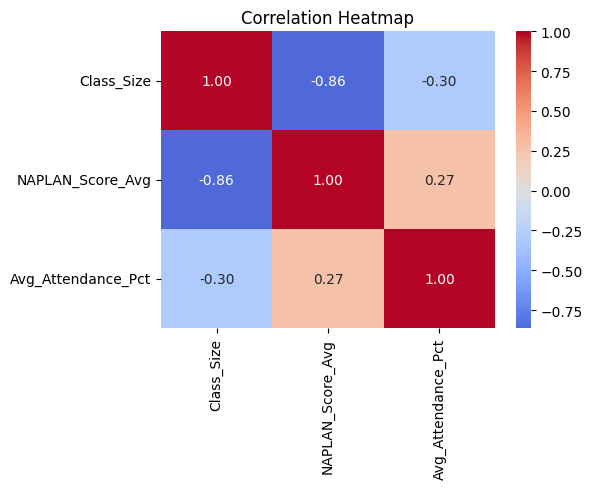

In [ ]:
# Correlation heatmap
# Worth checking the correlation btw class size and avgerage attendance %
fig, ax = plt.subplots(figsize=(6, 5))
corr_matrix = merged[['Class_Size', 'NAPLAN_Score_Avg', 'Avg_Attendance_Pct']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax, fmt='.2f')
ax.set_title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=150)
plt.show()

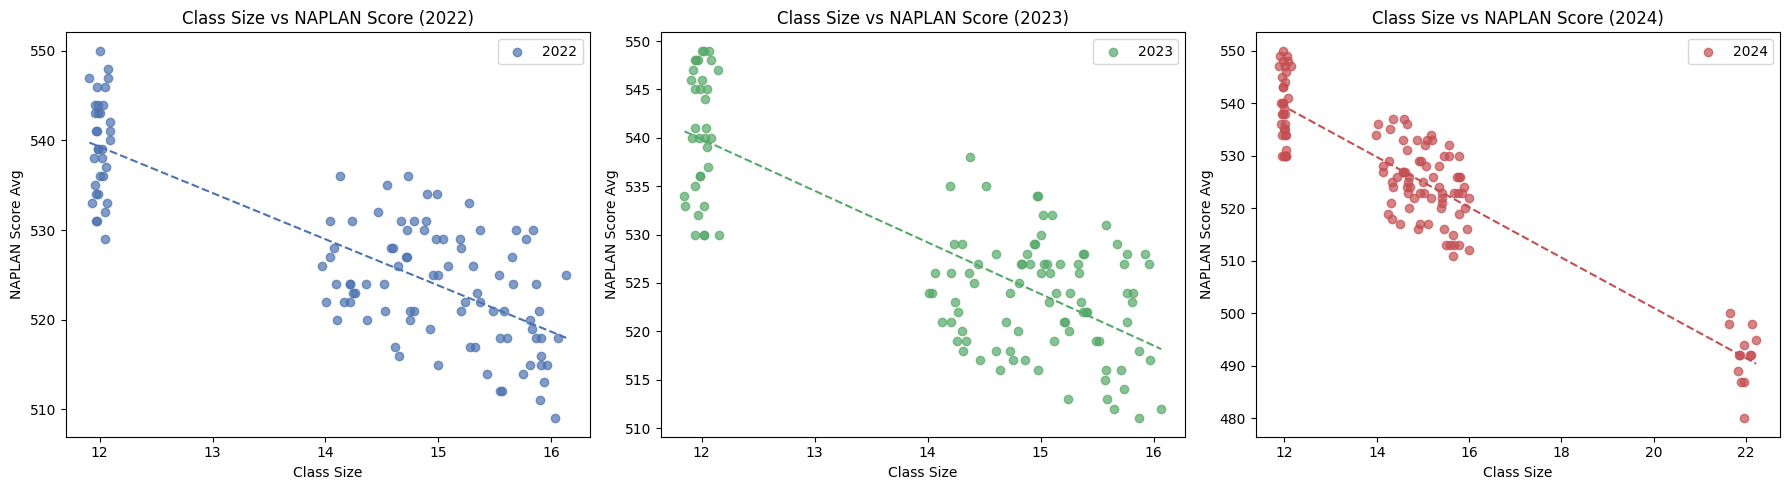

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = {2022: '#4C72B0', 2023: '#55A868', 2024: '#C44E52'}

for i, year in enumerate(sorted(merged['Year'].unique())):
    subset = merged[merged['Year'] == year]
    axes[i].scatter(subset['Class_Size'], subset['NAPLAN_Score_Avg'],
                    label=str(year), color=colors[year], alpha=0.7)

    # Trend line
    z = np.polyfit(subset['Class_Size'], subset['NAPLAN_Score_Avg'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(subset['Class_Size'].min(), subset['Class_Size'].max(), 100)
    axes[i].plot(x_line, p(x_line), color=colors[year], linestyle='--')

    axes[i].set_xlabel('Class Size')
    axes[i].set_ylabel('NAPLAN Score Avg')
    axes[i].set_title(f'Class Size vs NAPLAN Score ({year})')
    axes[i].legend()

plt.tight_layout()
plt.show()

# EDA - Checking Missing Value for *raw_funding_requests*

In [ ]:
funding.head()

,Request_ID,School_ID,Request_Date,Category,Status,Amount,Status_Date
0,REQ1000,2025,2022-02-03,Stem Lab,Declined,250000.0,2022-02-13
1,REQ1001,2066,2022-05-25,Capital Works,Pending,100000.0,2022-05-29
2,REQ1002,2025,2022-05-18,STEM Lab,Declined,50000.0,2022-05-23
3,REQ1003,2091,2023-04-06,IT Upgrade,Submitted,5000.0,2023-04-11
4,REQ1004,2061,2023-02-24,I.T. Upgrade,Declined,250000.0,2023-02-25


In [ ]:
funding_sorted = funding.sort_values(by='Request_ID').reset_index(drop=True)
print("Funding data sorted by Request_ID:")
funding_sorted.head()

Funding data sorted by Request_ID:


,Request_ID,School_ID,Request_Date,Category,Status,Amount,Status_Date
0,REQ1000,2025,2022-02-03,Stem Lab,Declined,250000.0,2022-02-13
1,REQ1001,2066,2022-05-25,Capital Works,Pending,100000.0,2022-05-29
2,REQ1002,2025,2022-05-18,STEM Lab,Declined,50000.0,2022-05-23
3,REQ1003,2091,2023-04-06,IT Upgrade,Submitted,5000.0,2023-04-11
4,REQ1004,2061,2023-02-24,I.T. Upgrade,Declined,250000.0,2023-02-25


In [ ]:
# Overview of missing values
print("=== Missing Values Overview ===")
print(funding.isnull().sum())

=== Missing Values Overview ===
Request_ID       0
School_ID        0
Request_Date     0
Category         0
Status           0
Amount          12
Status_Date      0
dtype: int64


In [ ]:
funding['Category'].unique()

array(['Stem Lab', 'Capital Works', 'STEM Lab', 'IT Upgrade',
       'I.T. Upgrade', 'Cap Works', 'Sports Equipment', 'Sports Equip',
       'Maintenance'], dtype=object)

In [ ]:
# Standarise Category Names
category_mapping = {
    'Stem Lab': 'STEM Lab',
    'I.T. Upgrade': 'IT Upgrade',
    'Cap Works': 'Capital Works',
    'Sports Equip': 'Sports Equipment'
}

funding['Category'] = funding['Category'].replace(category_mapping)

print("=== Category counts after standardisation ===")
print(funding['Category'].value_counts())

=== Category counts after standardisation ===
Category
IT Upgrade          28
Sports Equipment    27
Capital Works       22
STEM Lab            18
Maintenance         17
Name: count, dtype: int64


In [ ]:
duplicate_request_ids = funding['Request_ID'].value_counts()
duplicate_request_ids = duplicate_request_ids[duplicate_request_ids > 1]

if not duplicate_request_ids.empty:
    print("Duplicate Request_IDs found:")
    print(duplicate_request_ids)
else:
    print("No duplicate Request_IDs found.")

Duplicate Request_IDs found:
Request_ID
REQ1052    2
REQ1064    2
REQ1048    2
REQ1039    2
REQ1068    2
REQ1069    2
REQ1074    2
REQ1073    2
REQ1083    2
REQ1099    2
REQ1094    2
REQ1091    2
Name: count, dtype: int64


In [ ]:
# Deduplicate by keeping the latest Status_Date record
funding['Status_Date'] = pd.to_datetime(funding['Status_Date'])

funding = (
    funding.sort_values('Status_Date')
    .drop_duplicates(subset='Request_ID', keep='last')
    .reset_index(drop=True)
)

print(f"=== Shape after deduplication: {funding.shape} ===")

=== Shape after deduplication: (100, 7) ===


In [ ]:
# Overview of missing values
print("=== Missing Values Overview ===")
print(funding.isnull().sum())

=== Missing Values Overview ===
Request_ID       0
School_ID        0
Request_Date     0
Category         0
Status           0
Amount          10
Status_Date      0
dtype: int64


Now there are only 10 missing values!

# Backfill Missing Amount - Fallback Hierarchy

In [ ]:
# Australian financial year runs July 1 - June 30
# e.g. July 2022 - June 2023 = FY2023
funding['Request_Date'] = pd.to_datetime(funding['Request_Date'])
funding['Financial_Year'] = funding['Request_Date'].apply(
    lambda x: x.year + 1 if x.month >= 7 else x.year
)

In [ ]:
# Merge with schools to get Region and Sector
funding = funding.merge(schools, on='School_ID')

In [ ]:
funding.tail()

,Request_ID,School_ID,Request_Date,Category,Status,Amount,Status_Date,Financial_Year,School_Name,Region,Sector
95,REQ1086,2101,2023-10-28,Maintenance,Pending,NaN,2023-11-07,2024,Sunnyfield Public,Metro West,Government
96,REQ1073,2088,2023-10-21,Sports Equipment,Approved,5000.0,2023-11-10,2024,Eastwood Academy,Coastal East,Government
97,REQ1035,2075,2023-11-18,Sports Equipment,Approved,250000.0,2023-11-21,2024,Valleywood High,Metro West,Government
98,REQ1041,2018,2023-11-24,STEM Lab,Submitted,15000.0,2023-11-30,2024,Harbourside High,Regional West,Catholic
99,REQ1097,2027,2023-11-29,IT Upgrade,Submitted,10000.0,2023-12-01,2024,Hillsbank Tech,Metro South,Catholic


Fallback Hierarchy (most specific → broadest):
  1. School_ID + Category + Financial Year
  2. Category + Region + Financial Year
  3. Category + Region
  4. Category

Level 1 has no minimum group size (school's own data is always relevant)

Levels 2-4 require at least MIN_GROUP_SIZE data points

MIN_GROUP_SIZE = 3 is a threshold that controls the minimum number of data points a group needs to have before we trust its average for backfilling.

In [ ]:
MIN_GROUP_SIZE = 3

fallback_levels = [
    ['Category', 'Region', 'Financial_Year'],
    ['Category', 'Region'],
    ['Category']
]

missing_mask = funding['Amount'].isna()

for idx, row in funding[missing_mask].iterrows():
    filled = False

    # Level 1: School_ID + Category + Financial Year
    # Only use within the same FY to avoid embedding inflation across years
    school_cat_fy_mask = (
        (funding['School_ID'] == row['School_ID']) &
        (funding['Category'] == row['Category']) &
        (funding['Financial_Year'] == row['Financial_Year']) &
        (funding['Amount'].notna())
    )
    school_cat_fy_group = funding.loc[school_cat_fy_mask, 'Amount']

    if len(school_cat_fy_group) > 0:
        funding.loc[idx, 'Amount'] = school_cat_fy_group.mean()
        print(f"{row['Request_ID']}: filled using School_ID + Category + FY → ${school_cat_fy_group.mean():,.0f} (n={len(school_cat_fy_group)})")
        filled = True

    # Levels 2-4: Category + Region + FY → Category + Region → Category
    if not filled:
        for level in fallback_levels:
            mask = funding['Amount'].notna()
            for col in level:
                mask &= funding[col] == row[col]

            group = funding.loc[mask, 'Amount']

            if len(group) >= MIN_GROUP_SIZE:
                funding.loc[idx, 'Amount'] = group.mean()
                print(f"{row['Request_ID']}: filled using {level} → ${group.mean():,.0f} (n={len(group)})")
                filled = True
                break

    if not filled:
        print(f"{row['Request_ID']}: WARNING - no group met minimum size, using Category fallback")

# Round to whole numbers
funding['Amount'] = funding['Amount'].round().astype(int)

REQ1099: filled using ['Category'] → $89,118 (n=17)
REQ1095: filled using ['Category', 'Region'] → $121,667 (n=3)
REQ1017: filled using ['Category'] → $81,591 (n=22)
REQ1031: filled using ['Category', 'Region', 'Financial_Year'] → $55,000 (n=3)
REQ1047: filled using ['Category'] → $53,077 (n=13)
REQ1057: filled using ['Category'] → $72,391 (n=23)
REQ1064: filled using ['Category', 'Region', 'Financial_Year'] → $86,667 (n=3)
REQ1018: filled using School_ID + Category + FY → $5,000 (n=1)
REQ1084: filled using ['Category', 'Region'] → $66,000 (n=5)
REQ1086: filled using ['Category', 'Region'] → $46,667 (n=6)


In [ ]:
# Verify
print(f"Remaining missing Amounts: {funding['Amount'].isna().sum()}")

Remaining missing Amounts: 0


In [ ]:
# Save the cleaned file
funding['Request_Date'] = funding['Request_Date'].dt.strftime('%Y-%m-%d')
funding['Status_Date'] = funding['Status_Date'].dt.strftime('%Y-%m-%d')
funding.to_csv('raw_funding_requests_cleaned.csv', index=False)
print("Exported to raw_funding_requests_cleaned.csv")

Exported to raw_funding_requests_cleaned.csv


In [ ]:
# Download the file to local folder
from google.colab import files

files.download('raw_funding_requests_cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>